In [69]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
df=pd.read_csv("train_MpHjUjU.csv")

In [71]:
df.head(2)

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,2381060,2
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,-665480,2


Changing time to timestamp for better control.

In [72]:
from datetime import datetime, date
df['Time'] = list(map(lambda x: datetime.strptime(x, '%Y-%m-%d'), df['MMM-YY']))

In [73]:
df['Dateofjoining']=list(map(lambda x: datetime.strptime(x, '%Y-%m-%d'), df['Dateofjoining']))

Using 'Left' boolean value for better understanding, of who left and who stayed(0:Still Present, 1:Left/Leaving)

In [74]:
df['Left']=df.apply(lambda x: 0 if type(x['LastWorkingDate'])==float else 1, axis=1)

To estimate the total duration the employee has been with the organization, by subtracting the 'LastWorkingDate' and 'Dateofjoining'.(Note: I have used default date of last day of 2017 "31st Dec,2017" for employees marked as retained)

In [75]:
dr=[]
for d in df['LastWorkingDate'].index:
    if type(df['LastWorkingDate'][d]) is not float:
        dr.append(str(datetime.strptime(df['LastWorkingDate'][d], '%Y-%m-%d')-df['Dateofjoining'][d]))
    else:
        dr.append(str(datetime.strptime('2017-12-31', '%Y-%m-%d')-df['Dateofjoining'][d]))
#to convert duration list from datatype timestamp to integer
dur=[]
for i in dr:
    dur.append(int(i.replace(' days 00:00:00',"")))

In [76]:
df['Duration']=dur

Creating a dataset with all employee details

In [77]:
groupByID=df.groupby(['Emp_ID'])

In [78]:
#grouped by Employee ID
data=pd.DataFrame(groupByID.sum()[['Total Business Value','Left']])

In [79]:
data[['Duration','Highest_Ed','Gender','City','Salary']]=df[['Duration','Education_Level','Gender','City','Salary']]

In [80]:
#taking the last Quarter Ratings only
data['LastQuarterRating']=0
data['LastQuarterRating']=list(map((lambda x: df['Quarterly Rating'][df[df['Emp_ID']==x].last_valid_index()]),data.index))

In [81]:
#taking last assigned desination for the employee
data['Designation']=0
data['Designation']=list(map((lambda x: df['Designation'][df[df['Emp_ID']==x].last_valid_index()]),data.index))

In [82]:
data['Highest_Ed'].value_counts()

Bachelor    842
College     777
Master      762
Name: Highest_Ed, dtype: int64

Creating a numerical value for each Education Level 

In [83]:
highED=[]
highED=list(map(lambda x:1 if x=='College' else(2 if x=='Bachelor' else 3),data['Highest_Ed']))
data['Ed_Level']=highED

In [84]:
#Assigning last know age at the end of 2017
data['Age']=list(map(lambda x: int(df[df['Emp_ID']==x].nlargest(n=1,columns='Age',keep='last')['Age']),data.index))

In [85]:
data['City'].unique()

array(['C23', 'C7', 'C13', 'C9', 'C11', 'C2', 'C19', 'C26', 'C20', 'C17',
       'C29', 'C10', 'C24', 'C14', 'C6', 'C28', 'C5', 'C18', 'C27', 'C15',
       'C8', 'C25', 'C21', 'C1', 'C4', 'C3', 'C16', 'C22', 'C12'],
      dtype=object)

<AxesSubplot:xlabel='City'>

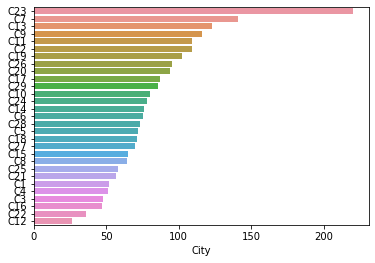

In [86]:
#to visulaize the demographic of the employees from a city
#plt.figure(figsize=(13,10))
sns.barplot(x=data['City'].value_counts(),y=data['City'].unique(),orient='h')

<AxesSubplot:xlabel='Age', ylabel='Count'>

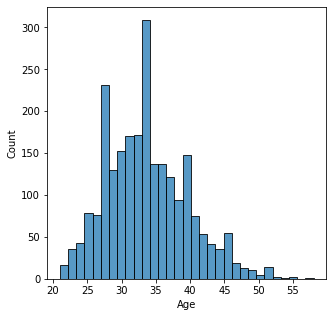

In [87]:
#to visulaize the age group of the employees from a city
plt.figure(figsize=(5,5))
sns.histplot(x=data['Age'])

<AxesSubplot:xlabel='Total Business Value', ylabel='Salary'>

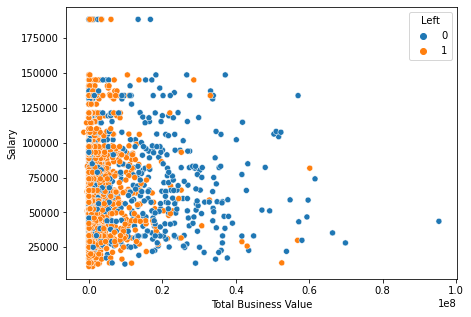

In [88]:
#to visulaize the relation between Salary and Business Value, in light of people who left and have still stayed
plt.figure(figsize=(7,5))
sns.scatterplot(x=data['Total Business Value'],y=data['Salary'],hue=data['Left'])

In [89]:
#sns.histplot(x=data['Total Business Value'])
data['Total Business Value'].describe()

count    2.381000e+03
mean     4.586742e+06
std      9.127115e+06
min     -1.385530e+06
25%      0.000000e+00
50%      8.176800e+05
75%      4.173650e+06
max      9.533106e+07
Name: Total Business Value, dtype: float64

<AxesSubplot:xlabel='LastQuarterRating', ylabel='Salary'>

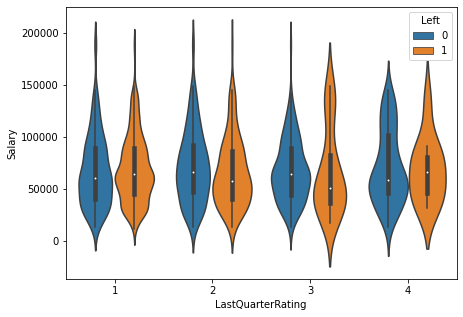

In [117]:
#to visulaize the relation between Salary and Last Quarter Rating, in light of people who left and have still stayed
plt.figure(figsize=(7,5))
sns.violinplot(x=data['LastQuarterRating'],y=data['Salary'],hue=data['Left'])

Trying to build a model using the dataset.

In [118]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

In [119]:
data['Male']=pd.get_dummies(data['Gender'])['Male']
#data.head()

<AxesSubplot:xlabel='count', ylabel='City'>

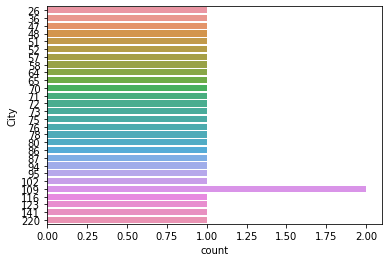

In [120]:
le=LabelEncoder()
data['City']=le.fit_transform(data['City'])
sns.countplot(y=data['City'].value_counts().sort_values())

In [121]:
#Setting the input and the output values.
X=data.drop(['Highest_Ed','Gender','Duration','Left'],axis=1)
y=data['Left']

In [122]:
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=101)

In [123]:
#Using Logistic Regression Model
lR=LogisticRegression()

In [124]:
lR.fit(X_train,y_train)

LogisticRegression()

In [125]:
pred=lR.predict(X_val)

In [126]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [127]:
print(classification_report(y_val,pred))

              precision    recall  f1-score   support

           0       0.69      0.35      0.47       156
           1       0.75      0.92      0.82       321

    accuracy                           0.74       477
   macro avg       0.72      0.64      0.65       477
weighted avg       0.73      0.74      0.71       477



In [128]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.56      0.40      0.47       156
           1       0.74      0.84      0.79       321

    accuracy                           0.70       477
   macro avg       0.65      0.62      0.63       477
weighted avg       0.68      0.70      0.69       477



In [129]:
print(confusion_matrix(y_val,pred))

[[ 55 101]
 [ 25 296]]


In [130]:
f1_score(y_val,pred)

0.8245125348189416

In [131]:
X.head(2)

,Total Business Value,City,Salary,LastQuarterRating,Designation,Ed_Level,Age,Male
Emp_ID,,,,,,,,
1,1715580,15,57387,2,1,3,28,1
2,0,15,57387,1,2,3,31,1


In [153]:
knn=KNeighborsClassifier()

In [133]:
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [134]:
y_pred=knn.predict(X_val)

In [135]:
f1_score(y_pred,y_val)

0.7912408759124088

In [136]:
f1_score(y_val,pred)

0.8245125348189416

In [137]:
test=pd.read_csv('test_hXY9mYw.csv')

In [111]:
#test['Emp_ID']

In [138]:
y_predLR=[]
y_predKN=[]
for i in test['Emp_ID']:
    y_predLR.append(int(lR.predict(X[X.index==i])))
    y_predKN.append(int(knn.predict(X[X.index==i])))

In [139]:
count1=0
count2=0
for i,j in zip(y_predLR, y_predKN):
    if i==j:
        count1=count1+1
    else:
        count2=count2+1
print(count1, count2)

598 143


In [140]:
#y_predLR

In [ ]:
#test.set_index('Emp_ID')

In [ ]:
#test.to_csv('Submission2.csv')

In [143]:
data.head(2)

,Total Business Value,Left,Duration,Highest_Ed,Gender,City,Salary,LastQuarterRating,Designation,Ed_Level,Age,Male
Emp_ID,,,,,,,,,,,,
1,1715580,1,738,Master,Male,15,57387,2,1,3,28,1
2,0,0,78,Master,Male,15,57387,1,2,3,31,1


In [144]:
from sklearn.preprocessing import StandardScaler

In [145]:
scale=StandardScaler()

In [146]:
data[['Total Business Value', 'Duration', 'Salary']]=scale.fit_transform(data[['Total Business Value', 'Duration', 'Salary']])

In [154]:
data.head(2)

,Total Business Value,Left,Duration,Highest_Ed,Gender,City,Salary,LastQuarterRating,Designation,Ed_Level,Age,Male
Emp_ID,,,,,,,,,,,,
1,-0.314641,1,-0.175577,Master,Male,15,-0.347121,2,1,3,28,1
2,-0.502646,0,-1.233524,Master,Male,15,-0.347121,1,2,3,31,1


In [160]:
X_scaled=data.drop(['Left','Gender','Highest_Ed'], axis=1)
y_scaled=data['Left']

In [161]:
X_tr,X_v,y_tr,y_v=train_test_split(X_scaled,y_scaled,test_size=0.2)

In [162]:
logicR=LogisticRegression()

In [163]:
logicR.fit(X_tr,y_tr)

c:\users\pc\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [164]:
y_pr=logicR.predict(X_v)

In [165]:
f1_score(y_v,y_pr)

0.8456973293768546

In [166]:
kNN=KNeighborsClassifier()

In [198]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [176]:
para={'n_neighbors':[2,3,4,5], 'weights' : ['uniform', 'distance']}

In [177]:
search=GridSearchCV(estimator=KNeighborsClassifier(),param_grid=para,verbose=2)

In [178]:
search.fit(X_tr,y_tr)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .....................n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END ....................n_neighbors=2, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=2, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=2, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=2, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=2, weights=distance; total time=   0.0s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=3, weig

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5],
                         'weights': ['uniform', 'distance']},
             verbose=2)

In [179]:
search.best_params_

{'n_neighbors': 5, 'weights': 'uniform'}

In [180]:
search.best_score_

0.7347617074181517

In [188]:
search2=GridSearchCV(RandomForestClassifier(),{'n_estimators':[100,150],'max_depth':[2,3]},verbose=1)

In [189]:
search2.fit(X_tr,y_tr)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 3], 'n_estimators': [100, 150]},
             verbose=1)

In [190]:
search2.best_params_

{'max_depth': 3, 'n_estimators': 100}

In [193]:
rdf=RandomForestClassifier(max_depth= 3, n_estimators= 100)

In [194]:
rdf.fit(X_tr,y_tr)

RandomForestClassifier(max_depth=3)

In [197]:
f1_score(y_v,(rdf.predict(X_v)))

0.8439821693907876

In [ ]:
adb=AdaBoostClassifier()